<a href="https://colab.research.google.com/github/tgarnier067/MNLP-project-2/blob/main/final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# READ ME

### Objective

This project focuses on automatically cleaning noisy OCR text using small LLMs. To do so, we use the OCRed text *The Vampyre* by John William Polidori.

We tested three different LLMs (and a combination of two of them) for text correction, evaluated in two ways:
- using a LLM-as-a-judge (here we use Gemini),
- and using manual human annotations (we annotated ourself the output of LLMs).

Our goals are:
1. To evaluate the reliability of LLMs-as-a-judge in assessing text corrections.
2. To investigate whether combining multiple correction models improves the final result.


> **This notebook only presents code to replciate the best-performing model: BART.**  
> For a full overview, including detailed analysis of all tested models, please visit our [GitHub repository](https://github.com/tgarnier067/MNLP-project-2), where the entire methodology is explained.

---

### How the Notebook Works

This notebook is designed to be **modular and reproducible**.

For many cells, you can controll the variable `run`:
- `run = True` → the cell runs and generates fresh outputs.
- `run = False` → precomputed data is loaded from Google Drive.

To use **LLM-as-a-judge**, simply provide your API key via the `api_key` variable:
- If `api_key` is empty, existing judgment scores are loaded.
- Otherwise, the notebook sends requests to the LLM to compute new scores.

All steps (data loading, cleaning, evaluation, exporting) can be run independently.

---

### Output Files

At the end of the notebook, the following `.json` files are generated and automatically downloadable using `files.download(...)` in Google Colab:

##### Corrected texts by model
- `Pythoms-hw2_ocr-ocr.json` → Original OCR input
- `Pythoms-hw2_ocr-bart.json` → Correction by BART *(best model)*
- `Pythoms-hw2_ocr-t5.json` → Correction by T5
- `Pythoms-hw2_ocr-back_translation.json` → Correction by back-translation
- `Pythoms-hw2_ocr-back_translation_t5.json` → Back-translation + T5 combination

##### First 5000 tokens of the best model : BART
- `Pythoms-hw2_ocrfirst_5k_tokens.json`

##### LLM-as-a-judge annotations : Gemini
- `Pythoms-hw2_ocr-judge_ocr.json`
- `Pythoms-hw2_ocr-judge_bart.json`
- `Pythoms-hw2_ocr-judge_t5.json`
- `Pythoms-hw2_ocr-judge_back_translation.json`
- `Pythoms-hw2_ocr-judge_back_translation_t5.json`

##### Manual annotations
- `Pythoms-hw2_ocr-manual_ocr.json`
- `Pythoms-hw2_ocr-manual_bart.json`
- `Pythoms-hw2_ocr-manual_t5.json`
- `Pythoms-hw2_ocr-manual_back_translation.json`
- `Pythoms-hw2_ocr-manual_back_translation_t5.json`

---

# Import Library

In [1]:
!pip install spacy --quiet
!python -m spacy download en_core_web_sm
!pip install transformers torch sentencepiece --quiet
!pip install google-generativeai --quiet
!pip install rouge_score spacy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import json
import os
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import spacy
import pandas as pd
from tqdm import tqdm
import time
from google.generativeai import GenerativeModel
import google.generativeai as genai
import warnings
import logging
import random
from rouge_score import rouge_scorer
import seaborn as sns
import matplotlib.pyplot as plt

# Import data

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
#path to json files
clean_path = '/content/drive/MyDrive/Pythoms_shared_folder/the_vampyre_clean.json'
ocr_path = '/content/drive/MyDrive/Pythoms_shared_folder/the_vampyre_ocr.json'

#load files
with open(clean_path, "r", encoding="utf-8") as f:
    clean_data = json.load(f)

with open(ocr_path, "r", encoding="utf-8") as f:
    ocr_data = json.load(f)

In [5]:
def concat_values_dict(d):
    """
    Concat values of a dict, seperating each element with '\n'

    Args:
        d (dict): Dictionnary

    Returns:
        str: concatenated text
    """
    return '\n'.join(d.get(str(i), "") for i in range(48))

clean_data_text = concat_values_dict(clean_data)

In [6]:
clean_data_text

'THE VAMPYRE;\nA Tale.\nBy John William Polidori\nTHE superstition upon which this tale is founded is very general in the East. Among the Arabians it appears to be common: it did not, however, extend itself to the Greeks until after the establishment of Christianity; and it has only assumed its present form since the division of the Latin and Greek churches; at which time, the idea becoming prevalent, that a Latin body could not corrupt if buried in their territory, it gradually increased, and formed the subject of many wonderful stories, still extant, of the dead rising from their graves, and feeding upon the blood of the young and beautiful. In the West it spread, with some slight variation, all over Hungary, Poland, Austria, and Lorraine, where the belief existed, that vampyres nightly imbibed a certain portion of the blood of their victims, who became emaciated, lost their strength, and speedily died of consumptions; whilst these human blood-suckers fattened—and their veins became 

# Model : BART

In [7]:
warnings.filterwarnings("ignore")

logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)

In [8]:
# IF YOU WANT TO RUN THE CORRECTION OF OCR TEXT BY BART, PLEASE, SET  run TO True

run = False

if run == True:

  # To split the text
  nlp = spacy.load("en_core_web_sm")

  #Load Bart model for OCR correction
  model_name = "pykale/bart-large-ocr"
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
  generator = pipeline('text2text-generation', model=model, tokenizer=tokenizer, device=0)

  # Function that take a text in input, and pass it through BART
  def correct_text_with_bart(text, max_length=1024):
      try:
          outputs = generator(text, max_length=max_length, num_beams=5, early_stopping=True)
          return outputs[0]['generated_text']
      except Exception as e:
          print(f"Erreur de correction : {e}")
          return text

  def split_into_sentences_spacy(text):
      doc = nlp(text)
      return [sent.text.strip() for sent in doc.sents if sent.text.strip()]

  def correct_text_by_line_and_sentence(text):
      lines = text.split('\n')
      corrected_lines = []

      for line in lines:
          if not line.strip():
              corrected_lines.append('')
              continue

          sentences = split_into_sentences_spacy(line)
          corrected_sentences = [correct_text_with_bart(sentence) for sentence in sentences]
          corrected_line = ' '.join(corrected_sentences)
          corrected_lines.append(corrected_line)

      return '\n'.join(corrected_lines)

  # Correction on all texts
  results = []

  for i in tqdm(range(len(ocr_data)), desc="OCR texts correction"):
      key = str(i)
      original_text = ocr_data[key]
      corrected_text = correct_text_by_line_and_sentence(original_text)
      results.append({
          "index": i,
          "original_text": original_text,
          "corrected_text": corrected_text
      })

  # Saving
  df = pd.DataFrame(results)
  df.to_csv("bart_correction.csv", index=False)

  print("Look at you csv files !!")

# LLM as a judge

Here are the criteria for the attribution of the score to corrected OCRed texts :

| **Score**         | **Criteria**                                                                                                                                                                    |
| ----------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1 - Very Poor** | The text remains largely unreadable. Numerous errors persist (spelling, grammar, punctuation). The overall meaning is lost or extremely unclear. Little to no improvement made. |
| **2 - Poor**      | Slightly more readable than the original, but many errors remain. Several sentences are incorrect or ambiguous. Words are still distorted or missing.                           |
| **3 - Fair**      | Most obvious errors have been corrected. The text is generally understandable, but noticeable mistakes and awkward phrasing remain. The flow may be choppy.                     |
| **4 - Good**      | The text is readable and coherent. Only minor errors remain. There’s overall consistency, though a few syntax or word choice issues may still be present.                       |
| **5 - Excellent** | The text is fully corrected: no detectable mistakes, perfect grammar, punctuation, and syntax. The result is fluent, natural, and faithful to the original content.             |

In [9]:
# IF YOU WANT TO RUN THE CODE, PLEASE, WRITE YOUR API KEY HERE

api_key = ""

if api_key != "":
  # Configure the API key and use Gemini model (we take a small model not to be limited by the API)
  genai.configure(api_key=api_key)
  model = GenerativeModel("gemini-2.0-flash-lite")

  # Function that divides text into chunks (we can not give the whole text as input => it's too big)
  def chunk_text(text, max_chunk_size=5000):
      chunks = []
      start = 0
      while start < len(text):
          end = start + max_chunk_size
          if end < len(text):
              last_space = text.rfind(" ", start, end)
              if last_space != -1 and last_space > start:
                  end = last_space
          chunks.append(text[start:end].strip())
          start = end
      return chunks

  # Build the prompt
  def build_prompt_score_only(chunk):
      return f"""You are a text quality evaluator. Evaluate the following corrected OCR text based on the detailed criteria below:

  1 - Very Poor: The text remains largely unreadable. Numerous errors persist (spelling, grammar, punctuation). The overall meaning is lost or extremely unclear. Little to no improvement made.
  2 - Poor: Slightly more readable than the original, but many errors remain. Several sentences are incorrect or ambiguous. Words are still distorted or missing.
  3 - Fair: Most obvious errors have been corrected. The text is generally understandable, but noticeable mistakes and awkward phrasing remain. The flow may be choppy.
  4 - Good: The text is readable and coherent. Only minor errors remain. There’s overall consistency, though a few syntax or word choice issues may still be present.
  5 - Excellent: The text is fully corrected: no detectable mistakes, perfect grammar, punctuation, and syntax. The result is fluent, natural, and faithful to the original content.

  Give only the numeric score (1 to 5). No explanation.

  Corrected Text:
  \"\"\"{chunk}\"\"\""""

  # Function that return the evaluation score for every chunks in a text
  def evaluate_text(text):
      chunks = chunk_text(text, max_chunk_size=5000)
      scores_for_text = []

      for i, chunk in enumerate(chunks):
          prompt = build_prompt_score_only(chunk)
          try:
              response = model.generate_content(prompt)
              raw_text = response.candidates[0].content.parts[0].text.strip()
              if raw_text in {"1", "2", "3", "4", "5"}:
                  score = int(raw_text)
              else:
                  score = -1
          except Exception as e:
              print(f"Error on chunk {i}: {e}")
              score = -1

          scores_for_text.append(score)
      return scores_for_text

  def main():
      folder_path = '/content/drive/MyDrive/Pythoms_shared_folder/'
      df = pd.read_csv(folder_path+"bart_correction.csv")
      all_scores = {}

      for text_index in range(len(df)):
          print(f"Processing text {text_index + 1} / {len(df)}...")
          text = df.loc[text_index, "corrected_text"]

          scores = evaluate_text(text)
          all_scores[text_index] = scores

          # 1 minute break because of the API
          if text_index < len(df) - 1:
              print("Waiting 60 seconds before next text...")
              time.sleep(60)

      rows = []
      for text_index, scores_list in all_scores.items():
          for chunk_index, score in enumerate(scores_list):
              rows.append({
                  "text_index": text_index,
                  "chunk_index": chunk_index,
                  "score": score
              })

      df_scores = pd.DataFrame(rows)
      df_scores.to_csv("Bart_gemini_scores_all_texts.csv", index=False)
      print("Over : Look at your new CSV files :) ")

  if __name__ == "__main__":
      main()

# Manual annotations

In [10]:
# If you want to annotate yourself the "cleaned" text by BART, please, set run to True

run = False

if run == True:

  def get_random_chunks(text, fixed_len=300):

      fixed_chunk = text[:fixed_len]

      start1 = random.randint(fixed_len, len(text) - 600)
      start2 = random.randint(start1 + fixed_len, len(text) - fixed_len)

      random_chunk_1 = text[start1:start1 + fixed_len]
      random_chunk_2 = text[start2:start2 + fixed_len]

      return fixed_chunk, random_chunk_1, random_chunk_2

  def ask_score(prompt):
      while True:
          try:
              score = int(input(f"{prompt} (1–5): "))
              if score in [1, 2, 3, 4, 5]:
                  return score
              else:
                  print("Score has to be between 1 and 5")
          except:
              print("Score has to be an integer, between 1 and 5")

  def main():
      folder_path = '/content/drive/MyDrive/Pythoms_shared_folder/'
      df = pd.read_csv(folder_path+"bart_correction.csv")
      results = []

      for idx, row in df.iterrows():
          print(f"\n=== Texte {idx} ===")
          text = row["corrected_text"]
          fixed, rand1, rand2 = get_random_chunks(text)

          print("\n🔹 Fixed sentence :")
          print(fixed)
          score_fixed = ask_score("Score for this part")

          print("\n🔹 First random sentence :")
          print(rand1)
          score_rand1 = ask_score("Score for this part")

          print("\n🔹 Second random sentence :")
          print(rand2)
          score_rand2 = ask_score("Score for this part")

          results.append({
              "text_index": idx,
              "fixed_chunk": fixed,
              "score_fixed": score_fixed,
              "random_chunk_1": rand1,
              "score_random_1": score_rand1,
              "random_chunk_2": rand2,
              "score_random_2": score_rand2
          })

      # Export CSV
      output_df = pd.DataFrame(results)
      output_df.to_csv("bart_manual_scores.csv", index=False)
      print("Look at you csv files !! ")

  if __name__ == "__main__":
      main()

# Correlation

We have applied this methods to many other models (LLM that correct the OCR mistakes), so we use it now to look at correclation, and plots. If you want to look at the code for all our models, with every output, please look at the google drive folder

## Import data

In [11]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [12]:
folder_path = '/content/drive/MyDrive/Pythoms_shared_folder/'


ocr_manual = pd.read_csv(folder_path + 'ocr_manual_scores.csv')
ocr_gemini = pd.read_csv(folder_path + 'ocr_gemini_scores.csv')

t5_manual = pd.read_csv(folder_path + 'T5_manual_scores.csv')
t5_gemini = pd.read_csv(folder_path + 'T5_gemini_scores_all_texts.csv')

bt_manual = pd.read_csv(folder_path + 'Back_translation_manual_scores.csv')
bt_gemini = pd.read_csv(folder_path + 'Back_translation_gemini_scores_all_texts.csv')

bart_manual = pd.read_csv(folder_path + 'bart_manual_scores.csv')
bart_gemini = pd.read_csv(folder_path + 'Bart_gemini_scores_all_texts.csv')

bt_t5_manual = pd.read_csv(folder_path + 'Back_translation_t5_manual_scores.csv')
bt_t5_gemini = pd.read_csv(folder_path + 'back_translation_t5_gemini_scores_all_texts.csv')

In [13]:
clean_path = '/content/drive/MyDrive/Pythoms_shared_folder/the_vampyre_clean.json'

with open(clean_path, "r", encoding="utf-8") as f:
    clean_data = json.load(f)

folder_path = '/content/drive/MyDrive/Pythoms_shared_folder/'


ocr_text = pd.read_csv(folder_path+"the_vampyre_ocr.csv")
bt_text = pd.read_csv(folder_path+"back_translation_correction.csv")
bart_text = pd.read_csv(folder_path+"bart_correction.csv")
t5_text = pd.read_csv(folder_path+"T5_correction.csv")
bt_t5_text = pd.read_csv(folder_path+"back_translation_t5_correction.csv")

## ROUGE

In [ ]:
# To slice into senteces
nlp = spacy.load("en_core_web_sm")


def get_first_n_sentences(text, n=20):
    doc = nlp(text)
    return ' '.join([sent.text.strip() for sent in list(doc.sents)[:n]])

# We only use the 20 first sentences to compute ROUGE scores
clean_trimmed = get_first_n_sentences(clean_data_text, n=20)


tables_info = [
    {'df': bt_text, 'gen_col': 'back_translated_text', 'label': 'Back-Translation'},
    {'df': bart_text, 'gen_col': 'corrected_text', 'label': 'BART'},
    {'df': t5_text, 'gen_col': 'corrected_text', 'label': 'T5'},
    {'df': ocr_text, 'gen_col': 'texte', 'label': 'OCR'},
    {'df': bt_t5_text, 'gen_col': 'corrected_text', 'label': 'Back-Translation + T5'}
]

# Initialize scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

results = []

# Compute the scores
for info in tables_info:
    df = info['df']
    col = info['gen_col']
    label = info['label']

    rouge1_scores = []
    rouge2_scores = []
    rougel_scores = []

    print(f"Looking at {label}")
    for pred_text in tqdm(df[col], desc=f"→ {label}", leave=False):
        pred_trimmed = get_first_n_sentences(pred_text, n=20)
        scores = scorer.score(clean_trimmed, pred_trimmed)

        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougel_scores.append(scores['rougeL'].fmeasure)

    results.append({
        'Method': label,
        'ROUGE-1': sum(rouge1_scores) / len(rouge1_scores),
        'ROUGE-2': sum(rouge2_scores) / len(rouge2_scores),
        'ROUGE-L': sum(rougel_scores) / len(rougel_scores),
    })

# Print
results_df = pd.DataFrame(results)
print(results_df)

Looking at Back-Translation


Looking at BART


→ BART:  77%|███████▋  | 37/48 [01:47<00:22,  2.04s/it]

## Compute final score for each text

In [ ]:
def compute_scores(df_manual, df_gemini):
    # Poids relatifs manuels
    manual_weights = [1.5, 1, 1]
    total_manual_weight = sum(manual_weights)

    # Poids normalisé pour chunk 0 dans Gemini (correspondant au score_fixed)
    weight_chunk0 = manual_weights[0] / total_manual_weight

    df_manual = df_manual.copy()
    norm_manual_weights = [w / total_manual_weight for w in manual_weights]

    # Calcul du score manuel pondéré
    df_manual['manual_score'] = df_manual[['score_fixed', 'score_random_1', 'score_random_2']].apply(
        lambda row: (
            row['score_fixed'] * norm_manual_weights[0] +
            row['score_random_1'] * norm_manual_weights[1] +
            row['score_random_2'] * norm_manual_weights[2]
        ),
        axis=1
    )

    df_gemini = df_gemini.copy()

    # Attribution des poids normalisés à chaque chunk
    def assign_normalized_weights(group):
        n_chunks = len(group)
        n_other_chunks = n_chunks - 1  # sauf chunk 0
        # Poids pour chunk 0
        group['normalized_weight'] = (1 - weight_chunk0) / n_other_chunks  # valeur par défaut
        group.loc[group['chunk_index'] == 0, 'normalized_weight'] = weight_chunk0
        return group

    df_gemini = df_gemini.groupby('text_index').apply(assign_normalized_weights).reset_index(drop=True)

    # Score pondéré Gemini
    gemini_scores = df_gemini.groupby('text_index').apply(
        lambda g: (g['score'] * g['normalized_weight']).sum()
    ).reset_index(name='gemini_score')

    # Fusion des résultats
    result = gemini_scores.merge(df_manual[['text_index', 'manual_score']], on='text_index')

    return result

## OCR

In [ ]:
scores_ocr = compute_scores(ocr_manual, ocr_gemini)
scores_ocr.head()

In [ ]:
correlation_t5 = scores_ocr['manual_score'].corr(scores_ocr['gemini_score'])

print(f"Correlation t5 (Pearson) : {correlation_t5:.3f}")

In [ ]:
df = scores_ocr.copy()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['gemini_score'], label='Gemini Scores', fill=True, linewidth=2)
sns.kdeplot(df['manual_score'], label='Manual Scores', fill=True, linewidth=2, color='orange')

gemini_mean = df['gemini_score'].mean()
manual_mean = df['manual_score'].mean()

plt.axvline(gemini_mean, color='blue', linestyle='--', linewidth=1.5, label=f'Gemini Mean: {gemini_mean:.2f}')
plt.axvline(manual_mean, color='orange', linestyle='--', linewidth=1.5, label=f'Manual Mean: {manual_mean:.2f}')

plt.title("Scores Density: Gemini vs Manual", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ocr_density.png")
plt.show()

## T5

In [ ]:
scores_t5 = compute_scores(t5_manual, t5_gemini)
scores_t5.head()

In [ ]:
scores_t5 = compute_scores(t5_manual, t5_gemini)
correlation_t5 = scores_t5['manual_score'].corr(scores_t5['gemini_score'])

print(f"Correlation t5 (Pearson) : {correlation_t5:.3f}")

In [ ]:
df = scores_t5.copy()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['gemini_score'], label='Gemini Scores', fill=True, linewidth=2)
sns.kdeplot(df['manual_score'], label='Manual Scores', fill=True, linewidth=2, color='orange')

gemini_mean = df['gemini_score'].mean()
manual_mean = df['manual_score'].mean()

plt.axvline(gemini_mean, color='blue', linestyle='--', linewidth=1.5, label=f'Gemini Mean: {gemini_mean:.2f}')
plt.axvline(manual_mean, color='orange', linestyle='--', linewidth=1.5, label=f'Manual Mean: {manual_mean:.2f}')

plt.title("Scores Density: Gemini vs Manual", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("t5_density.png")
plt.show()

## Back translation

In [ ]:
scores_bt = compute_scores(bt_manual, bt_gemini)
correlation_bt = scores_bt['manual_score'].corr(scores_bt['gemini_score'])
print(f"Correlation back translation (Pearson) : {correlation_bt:.3f}")

In [ ]:
df = scores_bt.copy()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['gemini_score'], label='Gemini Scores', fill=True, linewidth=2)
sns.kdeplot(df['manual_score'], label='Manual Scores', fill=True, linewidth=2, color='orange')

gemini_mean = df['gemini_score'].mean()
manual_mean = df['manual_score'].mean()

plt.axvline(gemini_mean, color='blue', linestyle='--', linewidth=1.5, label=f'Gemini Mean: {gemini_mean:.2f}')
plt.axvline(manual_mean, color='orange', linestyle='--', linewidth=1.5, label=f'Manual Mean: {manual_mean:.2f}')

plt.title("Scores Density: Gemini vs Manual", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("bt_density.png")
plt.show()

## BART

In [ ]:
scores_bart = compute_scores(bart_manual, bart_gemini)
correlation_bart = scores_bart['manual_score'].corr(scores_bart['gemini_score'])
print(f"Correlation back translation (Pearson) : {correlation_bart:.3f}")

In [ ]:
df = scores_bart.copy()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['gemini_score'], label='Gemini Scores', fill=True, linewidth=2)
sns.kdeplot(df['manual_score'], label='Manual Scores', fill=True, linewidth=2, color='orange')

gemini_mean = df['gemini_score'].mean()
manual_mean = df['manual_score'].mean()

plt.axvline(gemini_mean, color='blue', linestyle='--', linewidth=1.5, label=f'Gemini Mean: {gemini_mean:.2f}')
plt.axvline(manual_mean, color='orange', linestyle='--', linewidth=1.5, label=f'Manual Mean: {manual_mean:.2f}')

plt.title("Scores Density: Gemini vs Manual", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("bart_density.png")
plt.show()

## Back translation + T5

In [ ]:
scores_bt_t5 = compute_scores(bt_t5_manual, bt_t5_gemini)
scores_bt_t5.head()

In [ ]:
correlation_bt_t5 = scores_bt_t5['manual_score'].corr(scores_bt_t5['gemini_score'])

print(f"Correlation bt t5 (Pearson) : {correlation_bt_t5:.3f}")

In [ ]:
df = scores_bt_t5.copy()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['gemini_score'], label='Gemini Scores', fill=True, linewidth=2)
sns.kdeplot(df['manual_score'], label='Manual Scores', fill=True, linewidth=2, color='orange')

gemini_mean = df['gemini_score'].mean()
manual_mean = df['manual_score'].mean()

plt.axvline(gemini_mean, color='blue', linestyle='--', linewidth=1.5, label=f'Gemini Mean: {gemini_mean:.2f}')
plt.axvline(manual_mean, color='orange', linestyle='--', linewidth=1.5, label=f'Manual Mean: {manual_mean:.2f}')

plt.title("Scores Density: Gemini vs Manual", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("bt_t5_density.png")
plt.show()

## Gemini vs Manual

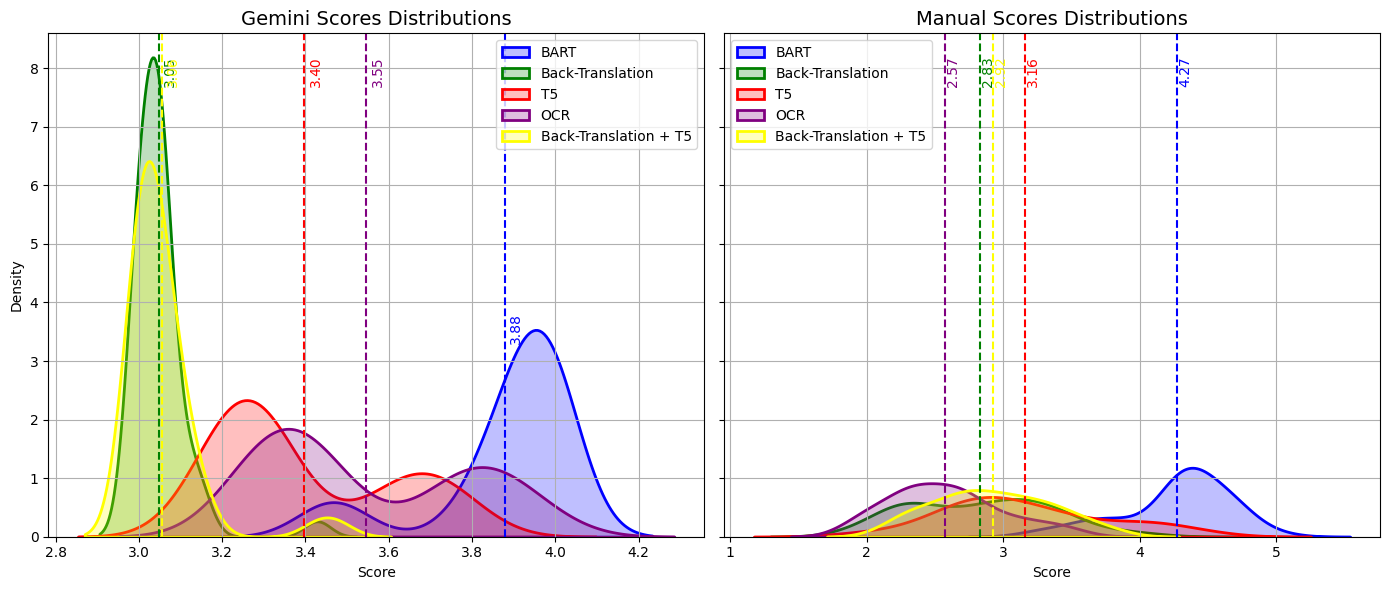

In [37]:
# Liste des DataFrames et des noms
dfs = [scores_bart, scores_bt, scores_t5, scores_ocr, scores_bt_t5]
labels = ['BART', 'Back-Translation', 'T5', 'OCR', 'Back-Translation + T5']
colors = ['blue', 'green', 'red', 'purple', 'yellow']

# Préparer une figure avec 2 sous-graphes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Plot des GEMINI scores ---
for df, label, color in zip(dfs, labels, colors):
    sns.kdeplot(df['gemini_score'], ax=axes[0], label=label, fill=True, linewidth=2, color=color)
    mean_val = df['gemini_score'].mean()
    axes[0].axvline(mean_val, color=color, linestyle='--', linewidth=1.5)
    axes[0].text(mean_val + 0.01, axes[0].get_ylim()[1]*0.9, f'{mean_val:.2f}', color=color, rotation=90)

axes[0].set_title("Gemini Scores Distributions", fontsize=14)
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(True)

# --- Plot des MANUAL scores ---
for df, label, color in zip(dfs, labels, colors):
    sns.kdeplot(df['manual_score'], ax=axes[1], label=label, fill=True, linewidth=2, color=color)
    mean_val = df['manual_score'].mean()
    axes[1].axvline(mean_val, color=color, linestyle='--', linewidth=1.5)
    axes[1].text(mean_val + 0.01, axes[1].get_ylim()[1]*0.9, f'{mean_val:.2f}', color=color, rotation=90)

axes[1].set_title("Manual Scores Distributions", fontsize=14)
axes[1].set_xlabel("Score")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("gemini_vs_manual_density.png")
plt.show()

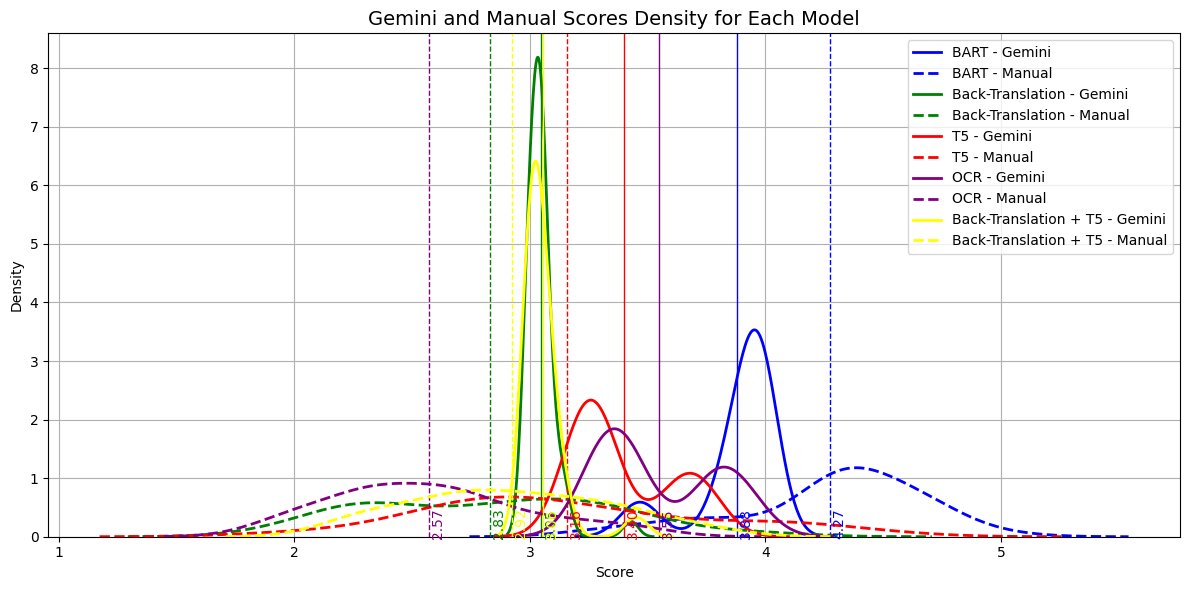

In [38]:
# Liste des DataFrames et des noms
dfs = [scores_bart, scores_bt, scores_t5, scores_ocr, scores_bt_t5]
labels = ['BART', 'Back-Translation', 'T5', 'OCR', 'Back-Translation + T5']
colors = ['blue', 'green', 'red', 'purple', 'yellow']

plt.figure(figsize=(12, 6))

# Tracer les courbes
for df, label, color in zip(dfs, labels, colors):
    # Gemini scores — ligne pleine
    sns.kdeplot(df['gemini_score'], label=f'{label} - Gemini', fill=False,
                linewidth=2, color=color, linestyle='-')
    gemini_mean = df['gemini_score'].mean()
    plt.axvline(gemini_mean, color=color, linestyle='-', linewidth=1)
    plt.text(gemini_mean + 0.01, 0.01, f'{gemini_mean:.2f}', color=color, rotation=90)

    # Manual scores — ligne pointillée
    sns.kdeplot(df['manual_score'], label=f'{label} - Manual', fill=False,
                linewidth=2, color=color, linestyle='--')
    manual_mean = df['manual_score'].mean()
    plt.axvline(manual_mean, color=color, linestyle='--', linewidth=1)
    plt.text(manual_mean + 0.01, 0.01, f'{manual_mean:.2f}', color=color, rotation=90)

plt.title("Gemini and Manual Scores Density for Each Model", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gemini_and_manual_density.png")
plt.show()

# Outputs files

## "Clean" Text

In [39]:
folder_path = '/content/drive/MyDrive/Pythoms_shared_folder/'


df_ocr = pd.read_csv(folder_path+"the_vampyre_ocr.csv")
df_bt = pd.read_csv(folder_path+"back_translation_correction.csv")
df_bart = pd.read_csv(folder_path+"bart_correction.csv")
df_t5 = pd.read_csv(folder_path+"T5_correction.csv")
df_bt_t5 = pd.read_csv(folder_path+"back_translation_t5_correction.csv")

In [43]:
df = df_ocr.copy()
model_name = 'ocr'

data_dict = dict(zip(df['id'], df['texte']))

with open(f"Pythoms-hw2_ocr-{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(data_dict, f, ensure_ascii=False, indent=4)

In [44]:
df = df_bt.copy()
model_name = 'back_translation'

data_dict = dict(zip(df['index'], df['back_translated_text']))

with open(f"Pythoms-hw2_ocr-{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(data_dict, f, ensure_ascii=False, indent=4)

In [45]:
df = df_bart.copy()
model_name = 'bart'

data_dict = dict(zip(df['index'], df['corrected_text']))

with open(f"Pythoms-hw2_ocr-{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(data_dict, f, ensure_ascii=False, indent=4)

In [46]:
df = df_t5.copy()
model_name = 't5'

data_dict = dict(zip(df['index'], df['corrected_text']))

with open(f"Pythoms-hw2_ocr-{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(data_dict, f, ensure_ascii=False, indent=4)

In [47]:
df = df_bt_t5.copy()
model_name = 'back_translation_t5'

data_dict = dict(zip(df['index'], df['corrected_text']))

with open(f"Pythoms-hw2_ocr-{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(data_dict, f, ensure_ascii=False, indent=4)

## LLM as a judge

In [48]:
folder_path = '/content/drive/MyDrive/Pythoms_shared_folder/'


df_ocr = pd.read_csv(folder_path + 'ocr_gemini_scores.csv')

df_t5 = pd.read_csv(folder_path + 'T5_gemini_scores_all_texts.csv')

df_bt = pd.read_csv(folder_path + 'Back_translation_gemini_scores_all_texts.csv')

df_bart = pd.read_csv(folder_path + 'Bart_gemini_scores_all_texts.csv')

df_bt_t5 = pd.read_csv(folder_path + 'back_translation_t5_gemini_scores_all_texts.csv')

In [49]:
df = df_ocr.copy()
model_name = 'ocr'

result = {}

for text_id, group in df.groupby('text_index'):
    chunks = group[['chunk_index', 'score']].to_dict(orient='records')
    result[str(text_id)] = chunks

with open(f"Pythoms-hw2_ocr-judge_{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

In [50]:
df = df_t5.copy()
model_name = 't5'

result = {}

for text_id, group in df.groupby('text_index'):
    chunks = group[['chunk_index', 'score']].to_dict(orient='records')
    result[str(text_id)] = chunks

with open(f"Pythoms-hw2_ocr-judge_{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

In [51]:
df = df_bt.copy()
model_name = 'back_translation'

result = {}

for text_id, group in df.groupby('text_index'):
    chunks = group[['chunk_index', 'score']].to_dict(orient='records')
    result[str(text_id)] = chunks

with open(f"Pythoms-hw2_ocr-judge_{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

In [52]:
df = df_bart.copy()
model_name = 'bart'

result = {}

for text_id, group in df.groupby('text_index'):
    chunks = group[['chunk_index', 'score']].to_dict(orient='records')
    result[str(text_id)] = chunks

with open(f"Pythoms-hw2_ocr-judge_{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

In [53]:
df = df_bt_t5.copy()
model_name = 'back_translation_t5'

result = {}

for text_id, group in df.groupby('text_index'):
    chunks = group[['chunk_index', 'score']].to_dict(orient='records')
    result[str(text_id)] = chunks

with open(f"Pythoms-hw2_ocr-judge_{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

## Manual annotations

In [54]:
folder_path = '/content/drive/MyDrive/Pythoms_shared_folder/'


df_ocr = pd.read_csv(folder_path + 'ocr_manual_scores.csv')

df_t5 = pd.read_csv(folder_path + 'T5_manual_scores.csv')

df_bt = pd.read_csv(folder_path + 'Back_translation_manual_scores.csv')

df_bart = pd.read_csv(folder_path + 'bart_manual_scores.csv')

df_bt_t5 = pd.read_csv(folder_path + 'Back_translation_t5_manual_scores.csv')

In [56]:
df = df_ocr.copy()
model_name = 'ocr'

result = {}

for _, row in df.iterrows():
    text_id = str(row['text_index'])

    chunks = [
        {"type": "fixed", "text": row['fixed_chunk'], "score": row['score_fixed']},
        {"type": "random_1", "text": row['random_chunk_1'], "score": row['score_random_1']},
        {"type": "random_2", "text": row['random_chunk_2'], "score": row['score_random_2']}
    ]

    result[text_id] = chunks

with open(f"Pythoms-hw2_ocr-manual_{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

In [57]:
df = df_t5.copy()
model_name = 't5'

result = {}

for _, row in df.iterrows():
    text_id = str(row['text_index'])

    chunks = [
        {"type": "fixed", "text": row['fixed_chunk'], "score": row['score_fixed']},
        {"type": "random_1", "text": row['random_chunk_1'], "score": row['score_random_1']},
        {"type": "random_2", "text": row['random_chunk_2'], "score": row['score_random_2']}
    ]

    result[text_id] = chunks

with open(f"Pythoms-hw2_ocr-manual_{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

In [58]:
df = df_bt.copy()
model_name = 'back_translation'

result = {}

for _, row in df.iterrows():
    text_id = str(row['text_index'])

    chunks = [
        {"type": "fixed", "text": row['fixed_chunk'], "score": row['score_fixed']},
        {"type": "random_1", "text": row['random_chunk_1'], "score": row['score_random_1']},
        {"type": "random_2", "text": row['random_chunk_2'], "score": row['score_random_2']}
    ]

    result[text_id] = chunks

with open(f"Pythoms-hw2_ocr-manual_{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

In [59]:
df = df_bart.copy()
model_name = 'bart'

result = {}

for _, row in df.iterrows():
    text_id = str(row['text_index'])

    chunks = [
        {"type": "fixed", "text": row['fixed_chunk'], "score": row['score_fixed']},
        {"type": "random_1", "text": row['random_chunk_1'], "score": row['score_random_1']},
        {"type": "random_2", "text": row['random_chunk_2'], "score": row['score_random_2']}
    ]

    result[text_id] = chunks

with open(f"Pythoms-hw2_ocr-manual_{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

In [60]:
df = df_bt_t5.copy()
model_name = 'back_translation_t5'

result = {}

for _, row in df.iterrows():
    text_id = str(row['text_index'])

    chunks = [
        {"type": "fixed", "text": row['fixed_chunk'], "score": row['score_fixed']},
        {"type": "random_1", "text": row['random_chunk_1'], "score": row['score_random_1']},
        {"type": "random_2", "text": row['random_chunk_2'], "score": row['score_random_2']}
    ]

    result[text_id] = chunks

with open(f"Pythoms-hw2_ocr-manual_{model_name}.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

## First 5000 characters

In [61]:
folder_path = '/content/drive/MyDrive/Pythoms_shared_folder/'
bart_text = pd.read_csv(folder_path+"bart_correction.csv")

bart_text.head()

,index,original_text,corrected_text
0,0,THE VAMPYRE;\nA Tale.\nBy John William Polidor...,THE VAMPYRE.\nA Tale.\nBy John William Polidor...
1,1,THE VAMPYRE;\nA Tale.\nBy Johri William Polido...,THE VAMPYRE.\nA Tale.\nBy John William Polidor...
2,2,THE VAMPYRE;\nA Tale.\nBy John William Polidor...,THE VAMPYRE.\nA Tale.\nBy John William Polidor...
3,3,THE VAMPYRE;\nA Tale.\nBy John Wjlliam Polidor...,THE VAMPYRE.\nA Tale.\nBy John William Polidor...
4,4,THE VAMPYRE;\nA Tale.\nBy Jahn William PoIjdor...,THE VAMPYRE.\nA Tale.\nBy John William Porter\...


In [63]:
lines = bart_text['corrected_text'][0].split('\n')[:24]

indexed_lines = {i: line for i, line in enumerate(lines)}

with open('Pythoms-hw2_ocr_first_5k_tokens.json', 'w', encoding='utf-8') as f:
    json.dump(indexed_lines, f, ensure_ascii=False, indent=4)

# Downloading

In [ ]:
from google.colab import files

# Download the corrected texts
files.download("Pythoms-hw2_ocr-back_translation.json")
files.download("Pythoms-hw2_ocr-back_translation_t5.json")
files.download("Pythoms-hw2_ocr-bart.json")
files.download("Pythoms-hw2_ocr-ocr.json")
files.download("Pythoms-hw2_ocr-t5.json")

# Download the 5k first token, of our best model
files.download("Pythoms-hw2_ocrfirst_5k_tokens.json")

# Download the gemini scores for the corrected texts
files.download("Pythoms-hw2_ocr-judge_back_translation.json")
files.download("Pythoms-hw2_ocr-judge_back_translation_t5.json")
files.download("Pythoms-hw2_ocr-judge_bart.json")
files.download("Pythoms-hw2_ocr-judge_ocr.json")
files.download("Pythoms-hw2_ocr-judge_t5.json")

# Download our manual scores for the corrected texts
files.download("Pythoms-hw2_ocr-manual_back_translation.json")
files.download("Pythoms-hw2_ocr-manual_back_translation_t5.json")
files.download("Pythoms-hw2_ocr-manual_bart.json")
files.download("Pythoms-hw2_ocr-manual_ocr.json")
files.download("Pythoms-hw2_ocr-manual_t5.json")